In [1]:
import sys
sys.path.append('../..')
# import torchvision
# import torchvision.datasets as dset
# import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2
# from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch

from DLBio.pytorch_helpers import get_device

import matplotlib.pyplot as plt
import numpy as np
# import random
# from PIL import Image
# import PIL.ImageOps
import ds_ear_siamese
# from siamese_network_dataset import SiameseNetworkDataset
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
# Set Up All Configurations here
class Config():
    dataset_dir = '../AMIC/'
    # training_dir = "../data/ears/training/"
    # testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    test_batch_size = 1
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 10
    LEARNINGRATE = 0.001

In [4]:
# define indicies to split Data
N = len(ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transform_mode='size_only'))
print(N)
n_80 = int(round(.8*N))
n_70 = int(round(.7*N))
n_60 = int(round(.6*N))
n_30 = int(round(.3*N))
n_20 = int(round(.2*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_70]
test_indices = rand_indices[n_30:]

# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    indices=train_indices,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform? 
    data_path=Config.dataset_dir
)

# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = ds_ear_siamese.get_dataloader(
    indices=test_indices,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    data_path=Config.dataset_dir
)

vis_dataloader = ds_ear_siamese.get_dataloader(
        indices=train_indices,
        batch_size=Config.vis_batch_size,
        num_workers=Config.num_workers,
        transform_mode='siamese',
        data_path=Config.dataset_dir
)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100']
700


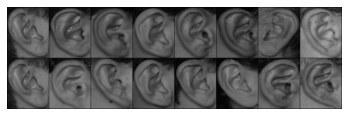

[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [5]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
# Definde Model and load to device
model = mobilenet_v2(pretrained=True)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=10)

device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss()
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)

cuda:0


In [ ]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, 
                loss_contrastive=contrastive_loss_siamese)

counter, loss_history = training(Config.EPOCHS)
show_plot(counter, loss_history)

In [ ]:
# Takes first image from the first batch of the test_dataloader and compares it via euclidean distance
# to the second entry images of the next ten batches (batch size is 1 here)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1 = model(Variable(x0).cuda())
    output2 = model(Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

